# Lab 3:  Bayesian Estimation in Hierarchical Graphical Models
Welcome to the third Data 102 lab! 

The code and responses you need to write are commented out with a message **"TODO: fill in"**. There is additional documentation for each part as you go along.


## Collaboration Policy
Data science is a collaborative activity. While you may talk with others about the labs, we ask that you **write your solutions individually**. If you do discuss the assignments with others please **include their names** in the cell below.

## Gradescope Submission
To submit this assignment, rerun the notebook from scratch (by selecting Kernel > Restart & Run all), and then print as a pdf (File > download as > pdf) and submit it to Gradescope.


**This assignment should be completed and submitted before Tuesday, Sep 22nd, 2020 at 11:59 PM. PST**

## Collaborators
Write the names of your collaborators in this cell.

`<Collaborator Name> <Collaborator e-mail>`

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import beta, binom
import itertools
from ipywidgets import interact, interactive

import hashlib
%matplotlib inline

sns.set(style="dark")
plt.style.use("ggplot")

def get_hash(num, significance = 4):
    num = round(num, significance)
    """Helper function for assessing correctness"""
    return hashlib.md5(str(num).encode()).hexdigest()

## Question 1: Beta-Binomial Graphical Model

In this question we will look at the example that Prof. Steinhard talked briefly in class. 

In this problem we are trying to estimate the COVID infection risk in households. To do that we curate a list of K studies. Each study has an associated pair $(N_i, X_i)$ where $N_i$ denotes the number of susceptible individuals considered and $X_i$ is the number of them that became infected. In our modeling assumptions we assume that each susceptible person get's infected with probability $\theta_i$. In epidemiology this quantity is known as Secondary Attack Rate or SAR for short.

So let's say that we are trying to compare the studies and rank them in increasing order of infection risk. We would like to figure out the regions with the lowest SAR, as investigating them might direct us towards studying them more and understanding what contributed to their relative success. In the other direction we want to determine which are the regions with highest SAR because likely they most urgently are in need of intervention meassures.


In [2]:
# Read out a dataset 
study_df = pd.read_csv("study_df.csv", header=0)
print(study_df)

        Name    X    N
0    Study 0    3    8
1    Study 1    2   11
2    Study 2    6   12
3    Study 3    9   27
4    Study 4   11   38
5    Study 5   21   59
6    Study 6   27   79
7    Study 7   23   82
8    Study 8   26  120
9    Study 9   57  145
10  Study 10  118  262
11  Study 11  122  341


### 1.a Compute the trivial estimate of SAR


The most straingforward way to estimate the probability of infection (SAR) is to divide the number of infected cases to the number of susceptible cases. 

Compute this quantity in the cell below.

In [3]:
# TODO: Complete the function
def trivial_theta_estimate(N_value, X_value):
    """
    Computes the trivial estimate of the Secondary Attack Rate
    
    Inputs:
        N_value : int, number of susceptible individuals
        X_value : int, number of infected individuals
        
    Output:
        theta_est : float, estimate of probability of infection (SAR)
    """
    theta_est = X_value/N_value
    return theta_est

In [4]:
# Validation tests
n_test_array = [10, 100, 1000]
x_test_array = [10, 34, 852]
res_array = [trivial_theta_estimate(n, x_test_array[i]) for i,n in enumerate(n_test_array)]
hash_list=['e4c2e8edac362acab7123654b9e73432','149dd5056939405870c9bb50cbc8691c','83659da620f470d5a131b5a9c76cfee7']
for i,res in enumerate(res_array):
    assert get_hash(res) == hash_list[i]
print('Test passed!')

Test passed!


In [5]:
# Apply  'trivial_theta_estimate' to each row of the dataframe and add a new column to hold the result
study_df.apply(lambda row: trivial_theta_estimate(row['N'], row['X']), axis =1)

0     0.375000
1     0.181818
2     0.500000
3     0.333333
4     0.289474
5     0.355932
6     0.341772
7     0.280488
8     0.216667
9     0.393103
10    0.450382
11    0.357771
dtype: float64

**Trivial estimates suggest that both minimum and maximum probabilities of infection correspond to small studies.**

|      | Min     | Max     |
|------|---------|---------|
| Name | Study 1 | Study 2 |
| X    | 2       | 6       | 
| N    | 11      | 12      |
|$\theta$| 0.18  | 0.50    |


Intuitively, we wouldn't want to make policy decision based on such small studies alone. We would like to balance between strong evidence of the small studies and high confidence in estimates from larger studies.

Bayesian inference provides a flexible framework to balance our apriori beliefs with new evidence. Consider the following graphical model:


![](GM1.png)


Here are a few important quantities in Bayesian Inference. This lingo will be used at length in this course, so make sure you get familiar with it.  

### Joint Density:
The structure of the graphical model specified the full joint density of the parameters and data in the model. For this example the join density is:
$$p(\theta_1, \theta_2, \ldots, \theta_K, X_1, \ldots, X_K) = \prod_{\text{vertex $V$ in graph}}p(V|\text{parent of $V$}) = \prod_{i=1}^K \underbrace{p(\theta_i|\alpha, \beta)}_{\text{prior of $\theta_i$}} \prod_{i=1}^K \underbrace{p(X_i|\theta_i)}_{\text{likelihood of data $X_i$}}$$

The factorization of the joint density into products of priors and likelihoods is the key featuere of Hierarchical Models. It allows to take a complex $2K$ dimensional joint probability and factorize it into products of $1$ dimensional probabilities.

### Prior:  $\theta_i \sim Beta(\alpha, \beta)$
We have the prior distribution: 
$$p(\theta_i)= \theta_i^{\alpha-1}(1-\theta_i)^{\beta-1} \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)+\Gamma(\beta)}\propto_{\theta_i}\theta_i^{\alpha-1}(1-\theta_i)^{\beta-1}$$ 
where $\Gamma$ is the Gamma Function. Since the $\frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)+\Gamma(\beta)}$ does not depend on the value of $\theta$. It is a scaling factor that ensures that $p(\theta_i)$ is a valid probability function. This leads to a common notation in practice: $p(\theta_i)\propto_{\theta_i}\theta_i^{\alpha-1}(1-\theta_i)^{\beta-1}$. The symbol $\propto_{\theta_i}$ means _proportional in $\theta_i$_.

### Likelihood: $X_i|\theta \sim Binomial(N_i, \theta_i)$
Some textbooks denote the likelihood function as $p(X_i|\theta)$, while other denote it as $p_{\theta}(X_i)$. Here we will use the former.
$$p(X_i|\theta_i) = \binom{N_i}{X_i} \theta_i^{X_i}(1-\theta_i)^{N_i - X_i}$$

### Marginal: Unconditional distribution of $X_i$:
$$p(X_i) = \mathbb{E}_{\theta}[p(X_i|\theta_i)] = \int_{0}^1 p(X_i|\theta_i)p(\theta_i)\ d \theta_i$$

### Posterior: $\theta_i|X_i$
The goal of many estimation problems is to obtain the posterior distribution of the parameter of interest $\theta_i$ with respect to the data $X_i$.
\begin{align}
p(\theta_i|X_i) &= \frac{p(X_i|\theta_i)p(\theta_i)}{p(X_i)} \quad \text{by Bayes Rule}\\
&\propto_{\theta} p(X_i|\theta_i)p(\theta_i) \quad \text{the marginal does not depend on $\theta$}\\
&\propto_{\theta}  \underbrace{\theta_i^{X_i}(1-\theta_i)^{N_i - X_i}}_{\text{likelihood}} \underbrace{\theta^{\alpha-1}(1-\theta)^{\beta-1}}_{\text{prior}}\\
&\propto_{\theta}\theta_i^{\alpha + X_i - 1}(1-\theta_i)^{\beta + N_i - X_i - 1} \quad \text{unnormalized Beta density}\\
\end{align}

### Hence $\theta_i|X_i \sim Beta(\alpha + X_i, \beta + N_i - X_i)$


The fact that the posterior probability comes from the same distribution family is known as *conjugacy*. It is a very useful property because it allows us to compute the posteriors in close form.

### 1.b Examine the prior distribution

In [6]:
def plot_beta(alpha_value, beta_value):
    x = np.arange(0,1.01,0.01)
    y = beta.pdf(x, alpha_value, beta_value)
    fig = plt.figure()
    plt.plot(x, y)
    plt.xlabel('Support')
    plt.title('$\\theta_i \sim Beta(\\alpha, \\beta)$')
    plt.ylim(0, 10)
    plt.show() 

In [7]:
interactive_plot = interactive(plot_beta, alpha_value=(1, 20, 0.5), beta_value=(1,20, 0.5))
interactive_plot

interactive(children=(FloatSlider(value=10.0, description='alpha_value', max=20.0, min=1.0, step=0.5), FloatSl…

1.b (i) Hold `alpha_value = 5`, slide `beta_value`. Write 1 sentence of your observations.

As the beta value increases, the graph becomes more right skewed (mean/median decreases) and as the beta value decreases, the graph flattens out and eventually becomes more left skewed (mean/median increases).

1.b (ii) Hold `beta_value = 5`, slide `alpha_value`. Write 1 sentence of your observations.

As alpha incerases, the graph becomes more left skewed (mean/median increases) and there is less variance. As alpha decreases, the graph flattens out and becomes more right skewed (mean/median decreases) and there is more variance (wider graph).

1.b (iii) Set `alpha_value = beta_value = 1`, increase their value such that `alpha_value=beta_value`. Write 1 sentence of your observations.

The graph is centered at around 0.5 but as alpha = beta increases, the variance decreases and the graph becomes narrower and higher.

### 1.c Compute Posterior Mean Estimates for SAR
In Problem 2 of Discussion 3 we showed that the **posterior mean** minimizes the **Bayes Risk** for tbe **Squared Error Loss**. _(if this sounds confusing take another look at the derivation of Problem 2a in Discussion 3)_. 

#### In the cell below write a function that computes the posterior mean corresponding to $\theta_i|X_i$.

In [8]:
# TODO: complete the function
def posterior_mean_estimate(N_value, X_value, alpha_value, beta_value):
    """
    Computes the posterior E[theta_i|X_i] when we consider a prior theta_i ~ Beta(alpha, beta)
    
    Inputs: 
        N_value : int, total number of susceptible individuals
        X_value : int, number of individuals that became infected
        alpha_value, beta_value : floats, parameters of the prior Beta Distribution
    """
    alpha = alpha_value + X_value
    beta = beta_value + N_value - X_value

    posterior_mean = alpha/(beta+alpha)
    return posterior_mean
    

In [9]:
# Validation tests
N_test = 100
X_test = 20
alpha_test_array = [1, 10, 100]
beta_test_array = [1, 10, 100]
inputs = list(itertools.product(alpha_test_array, beta_test_array))
hash_list = ['8ae3cf8f9366cbdea2ccf7706546ba4a','f8ddc3234c0a54e55b01384bcfb23f90','82589ee1f18a2e0b9fe9d14836983102',
             '08cf5a2033e7e21ec90b6707c24facaf','70da82175ec8a195a3d8b0fa8f69681d','ced20bed08ecfba035cbc3e06657cff2',
             'c8a7feeaced214c662a999d9bf075e8c','790abc5c38e7c740420b03c24fabb05b','54fbf38cf649866815e0fefc46a1f6c7']
for i,inp in enumerate(inputs):
    assert hash_list[i] == get_hash(posterior_mean_estimate(N_test, X_test, *inp))
print('Test passed!')

Test passed!


### 1.d Examine the posterior mean estimate

Let's assume that from domain knowledge we expect probability of infection (SAR) to be around $\frac{1}{3}$. We pick a prior distribution for $\theta_i$'s that has mean $\frac{1}{3}$. Any distributiond of the form $\theta_i \sim Beta(k, 2k)$ has this property. The value of $k$ determines the 'strenght' of the prior. Low values of $k$  correspond to 'flatter' priors, while larger values of $k$ correspond to 'peakier' priors. Play with the sliders in **1.b** to convince yourself.

**Examine the plotting function below and answer the qualitative questions in the next cells.**

In [10]:
# Do not modify: Examine the code
def plot_thetas(k):
    
    study_df["bayesian_theta"] = study_df.apply(lambda row: posterior_mean_estimate(row['N'], row['X'], k, 2*k), axis =1)
    study_df["trivial_theta"] = study_df.apply(lambda row: trivial_theta_estimate(row['N'], row['X']), axis =1)
    fig = plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    graph = sns.scatterplot(x="trivial_theta", y="bayesian_theta", data=study_df, size="N", sizes=(50, 300), alpha=.8)
    sns.lineplot(x='trivial_theta', y='trivial_theta', data= study_df,  ls="--", color='k', lw= 1)
    plt.ylim(0.16, 0.52)
    graph.axhline(1/3,  ls="--", color='k', label = "$\frac{1}{3}$ Prior Expectation")
    plt.xlabel('Trivial Estimate')
    plt.ylabel('Posterior Mean Estimate')
    
    plt.subplot(1, 2, 2)
    x = np.arange(0,1.01,0.01)
    y = beta.pdf(x, k, 2*k)
    plt.plot(x, y)
    plt.xlabel('Support')
    plt.title('Prior $\\theta_i \sim Beta(\\alpha={}, \\beta={})$'.format(k, 2*k))
    plt.ylim(0, 10)
    plt.show()

In [11]:
interactive_plot = interactive(plot_thetas, k=(0, 50, 2))
interactive_plot

interactive(children=(IntSlider(value=24, description='k', max=50, step=2), Output()), _dom_classes=('widget-i…

In the plot above the horizontal dashed line represents the prior mean estimate $\mathbb{E}[\theta_i] = \frac{k}{k+2k} = 1/3$. The diagonal solid line marks $x=y$. Each data-point corresponds to a study, the size of the marker denotes the number of susceptible individuals in each study. Such that larger markers correspond to larger studies.

**Answer the following questions with 1-2 sentences each.**

1.d (i) Set $k=0$, what do you notice about the data points. Increase steadily the value of $k$. What happens with the points above the dashed line? What about the points below it?

At k = 0, the data points fall along the line. As the value of k increases, the points above the dashed line gets closer to the dashed line and the same is true for the points below the line.

1.d (ii) We see larger markers move 'slower' than smaller markers. How can you explain this?

Larger markers represent larger studies and thus those markers move slower than smaller markers because larger datasets are less likely to be affected by changing k values. There is less impact to the values of the larger set and thus the values change less and move "slower."

1.d (iii) Imagine that we let $k\to \infty$. How do you think the two graphs above will look in the limit $k\to \infty$? 

I think as k approaches infinite, the peak of the second graph will grow higher and the points in first graph will get closer and closer to the dashed line. 

## Question 2: 

### Note: DataHub is having issues with PyMC. We are trying to fix that. Download the notebook and run the rest on your local machine. We hope to address this issue soon.

In the previous question we looked at a Beta-Binomial Graphical model. We took advantage of the conjugacy properties of the model and were able to compute close form solutions for the posterior mean estimates.

However, as we introduce more complexity to the model, the conjugacy property quickly brakes and we have to resort to sampling techniques. Sampling techniques for approximate inference will be the topic of this week's lectures and next week's labs.

Before delving deeper, in this question you will get a taste for probabilistic programming using `PyMC3`. Spend some time perusing the [documentation](https://docs.pymc.io/), but don't worry if don't really understand what's going on. 

In [12]:
%%capture install
! pip install arviz==0.6.1
! pip install pymc3==3.8
! pip install Theano==1.0.4


## If this fails uncomment the 4 lines above
import pymc3 as pm

In [13]:
# Do not modify: Spend some time examining the code
def fit_approximate_inference(alpha_value, beta_value, study_df = study_df):
    """
    Creates and fits a PyMC3 model corresponding to the graphical model in Q.1
    
    Inputs:
        alpha_value, beta_value : floats, parameters of the prior Beta Distribution
        study_df : DataFrame containing study data
    
    Outputs: (model, trace)
    """
    with pm.Model() as model:
        theta = pm.Beta('theta', alpha=alpha_value, beta=beta_value, shape=len(study_df))
        X = pm.Binomial('X', p=theta, observed=study_df['X'], n=study_df['N'])
        trace = pm.sample(500, tune=1000, target_accept=0.95, random_seed = 0)
    return(model, trace)

In [14]:
# Do not modify
def sample_posterior_theta(model, trace):
    """
    Return samples from the posterior distribution theta_i|X_i
    
    Inputs:
        models, trace : PyPM3 objects, outputs of fit_approximate_inference
        
    Output:
        posterior_samples : (2000 x num_studies array), each column contains posterior samples for a theta_i
    """
    with model:
        posterior_samples = pm.sample_posterior_predictive(trace, var_names=["theta"], random_seed=0)['theta']
    return(posterior_samples)   

### 2.a Compute Empirical Posterior Mean Estimates from Samples

Fill in the function that computes posterior mean estimates for $\theta_i$'s for different parameters $\alpha, \beta$ of the prior distribution.

In [15]:
# TODO: complete the function
def empirical_posterior_mean_estimates(alpha_value, beta_value, study_df = study_df):
    """ 
    Computes posterior mean estimates of theta_i by performing approximate inference and then sampling from
    the posterior distribution:
    
    Inputs:
        alpha_value, beta_value : floats, parameters of the prior Beta Distribution
        study_df : DataFrame containing study data
        
    Output:
        posterior_estimates : (num_studies,) 1-D array of the same length as the number of studies,
                               posterior_estimates[i] contains the empirical posterior mean estimate for theta_i
    
    """
    posterior_estimates = []
    theta_i = fit_approximate_inference(alpha_value, beta_value, study_df = study_df)
    sample = sample_posterior_theta(theta_i[0], theta_i[1])
    for x in [list(i) for i in zip(*sample)]:
        posterior_estimates.append(np.mean(x))
    return posterior_estimates


In [16]:
# Validation tests: Do not modify
# Even if you don't pass the tests but get smth reasonably close to the numbers below you can consider it as passed

# Study 0:  0.303 
# Study 1:  0.261 
# Study 2:  0.340 
# Study 3:  0.307 
# Study 4:  0.287 
# Study 5:  0.329 
# Study 6:  0.325 
# Study 7:  0.282 
# Study 8:  0.232 
# Study 9:  0.372 
# Study 10:  0.433 
# Study 11:  0.352
    
posterior_estimates_test = empirical_posterior_mean_estimates(10,25)

for i, est in enumerate(posterior_estimates_test):
    print('Study {}:  {:.3f} '.format(i, est))

hash_list = ['e85b79abfd76b7c13b1334d8d8c194a5','261943f3a93b683ceeac658927f3923f','149dd5056939405870c9bb50cbc8691c', 
             'ba6197788db60f5e2cb45cd403fa6559','246c0903b5a64b2a854ec1e7865f174f','ffa243f771800363714f6055d9236fd6', 
             '9f4721cf71c0ed18cd60356036b953cc','45efc23f34e05a9ea4f5024988047dd6','8f11bfb91ec29936603314c7cbc46119', 
             'a3f2a910685f5b07f5f45a5fc1fdb389','91afec64e32d6bf957e441df2ab638bb','8ce3fac7e23a02ab4e00cf0f1e03310a']
for i, est in enumerate(posterior_estimates_test):
    assert hash_list[i] == get_hash(est, 2)
print("Test passed")

100%|██████████| 2000/2000 [00:00<00:00, 25987.74it/s]

Study 0:  0.301 
Study 1:  0.263 
Study 2:  0.340 
Study 3:  0.307 
Study 4:  0.288 
Study 5:  0.331 
Study 6:  0.325 
Study 7:  0.284 
Study 8:  0.232 
Study 9:  0.372 
Study 10:  0.432 
Study 11:  0.352 
Test passed


### 2.b Plot the theoretical distribution of the posterior from Question 1 and the empirical distribution of the posterior from Question 2.

Make 4x3 plot such that each subplot corresponds to a study. 

Each subplot should contain 2 curves and a frequency histogram:
- The P.D.F of the prior distribution of $\theta_i$
- The P.D.F. of the posterior distribution $\theta_i|X_i$ computed in closed form as in Q.1
- The histogram of posterior samples of $\theta_i|X_i$ computed in Q.2

Make sure that you properly label each curve and histogram and give each subplot a meaningful title.

To give you a mental image of what we have in mind here is a sample subplot:

![](sample_graph.png)

In [17]:
study_df

,Name,X,N,bayesian_theta,trivial_theta
0,Study 0,3,8,0.337500,0.375000
1,Study 1,2,11,0.313253,0.181818
2,Study 2,6,12,0.357143,0.500000
3,Study 3,9,27,0.333333,0.333333
4,Study 4,11,38,0.318182,0.289474
5,Study 5,21,59,0.343511,0.355932
6,Study 6,27,79,0.337748,0.341772
7,Study 7,23,82,0.305195,0.280488
8,Study 8,26,120,0.260417,0.216667
9,Study 9,57,145,0.373272,0.393103


In [18]:
# TODO: write the plotting function
def plot_densities(alpha_value, beta_value, study_df = study_df): 
    """
    Plots for each study the prior distribution, theoretical posterior 
    and histogram of empirical posterior samples
    
    Inputs:
        alpha_value, beta_value : floats, parameters of the prior Beta Distribution
        study_df : DataFrame containing study data
        
    Outputs:
        fig : Figure with 12 subplots
    """
    fig, axs = plt.subplots(4, 3)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    x = np.linspace(0,1, 5000)
    
    theta_i = fit_approximate_inference(alpha_value, beta_value, study_df = study_df)
    sample = sample_posterior_theta(theta_i[0], theta_i[1])
    arr = [list(i) for i in zip(*sample)]


    index = 0
    for i in range(0,4):
        for j in range(0, 3):
            axs[i][j].hist(arr[index], density=True, label = "Emperical Posterior")
            axs[i][j].plot(x, beta.pdf(x, alpha_value, beta_value), label='Prior')
            axs[i][j].plot(x, beta.pdf(x, alpha_value+study_df['X'][index], beta_value+study_df['N'][index]-study_df['X'][index]), label='Theoretical Posterior')
            axs[i][j].legend()
            index+=1
            
    
    plt.tight_layout()        
    plt.show()
    
    return(fig)

100%|██████████| 2000/2000 [00:00<00:00, 23460.50it/s]


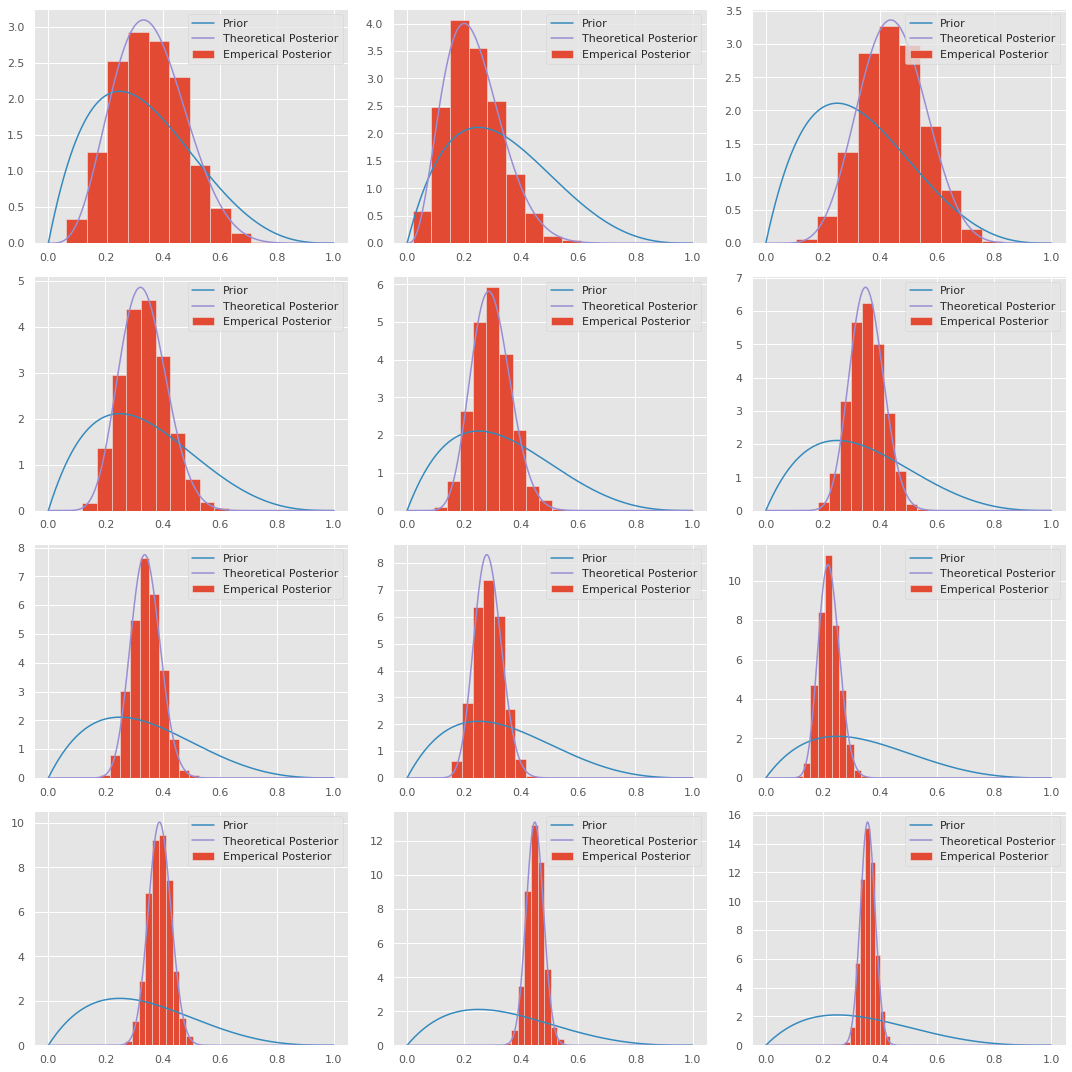

In [19]:
# Plot the resulting densities for a weak prior
fig1 = plot_densities(2, 4, study_df = study_df)

100%|██████████| 2000/2000 [00:00<00:00, 23891.34it/s]


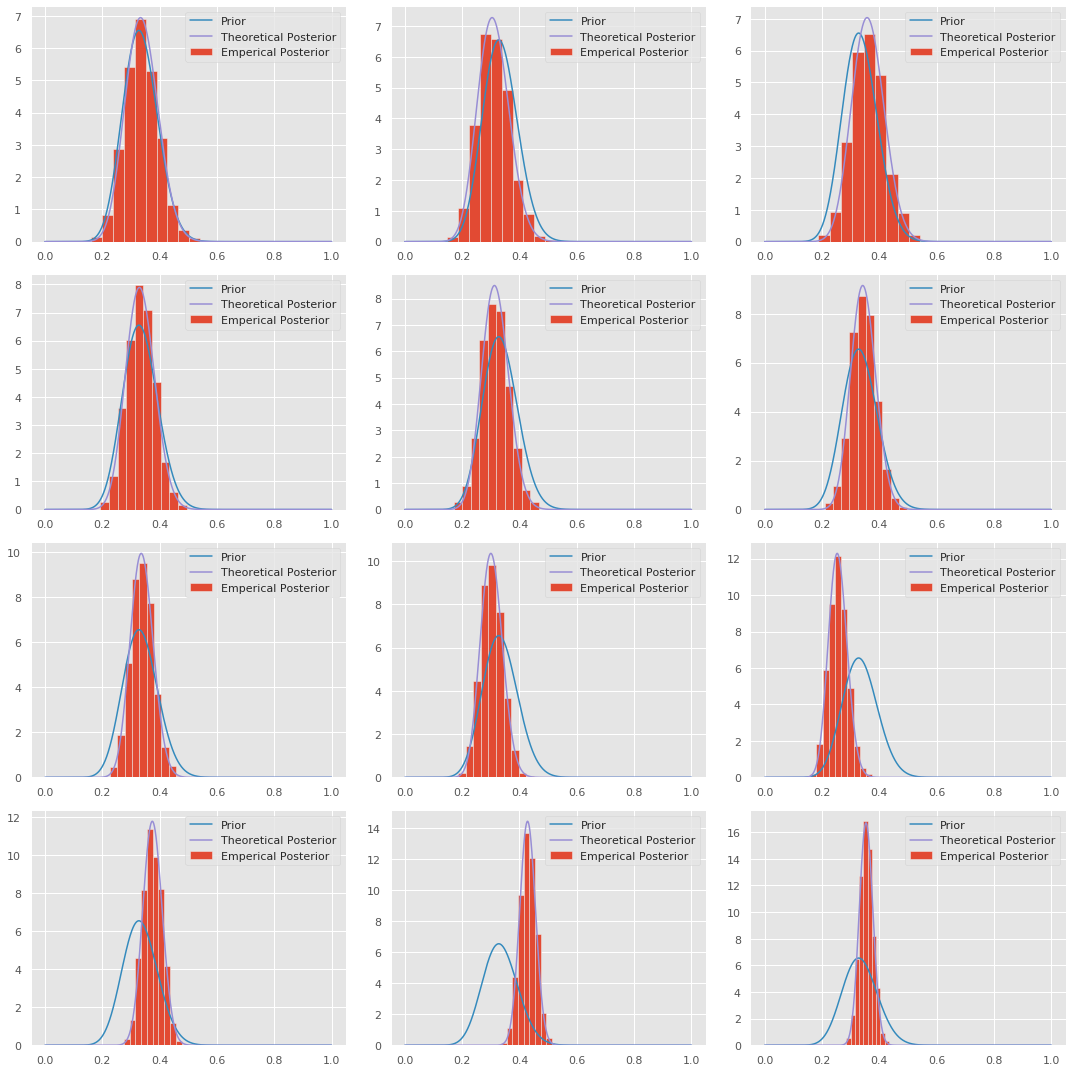

In [20]:
# Plot the resulting densities for a strong prior
fig2 = plot_densities(20, 40, study_df = study_df)

2.b (i) Compare the curve of the theoretical distribution with the histogram of samples from the empirical posterior

The curve of the theoretical distribution fits the shape of the histogram much better than the prior.

2.b (ii) Compare the two figures corresponding to 'weak' prior $\theta_i \sim Beta(2,4)$ and 'strong' prior  $\theta_i \sim Beta(20,40)$.

The strong prior fits the histogram much better than the weak prior for most graphs. The stronger priors have a higher peak than the weaker priors.

### 2.c Perform Approximate Inference on a more Complex Model

The previous 2 parts served as a sanity check that the approximate inference techniques used by PyMC3 can approximate the theoretical posterior. The usefulness of such packages becomes apparent when we are dealing with more complex models that don't have conjugacy properties.

Consider the following graphical model:

![](GM2.png)

Recent studies have shown that a large fraction of COVID cases do not show symptoms. The estimates of the asymptomatic rate fall in the range $[0.18, 0.43]$. We assume a prior $AR\sim Uniform(0.18, 0.43)$

All of the studies considered here tested only symptomatic cases, meaning that the probability that a person in a study tests positive is $\theta_i*(1-AR)$. Hence:
$$X_i|\theta_i, AR \sim Binomial(N_i, \theta_i\cdot (1-AR))$$

#### Complete `fit_approximate_inference_AR` function to add dependence on the asymptomatic rate:
`Hint`: Consider [pm.Uniform](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Uniform)

In [30]:
# TODO: complete the function
def fit_approximate_inference_AR(alpha_value, beta_value, study_df = study_df):
    """
    Creates and fits a PyMC3 model corresponding to the graphical model above
    
    Inputs:
        alpha_value, beta_value : floats, parameters of the prior Beta Distribution
        study_df : DataFrame containing study data
    
    Outputs: (model, trace)
    """
    with pm.Model() as model:
        theta = pm.Beta('theta', alpha=alpha_value, beta=beta_value, shape=len(study_df))
        AR = pm.Uniform('AR', lower=0.18, upper=0.43)
        X = pm.Binomial('X', p=theta*(1-AR), observed=study_df['X'], n=study_df['N'])
        trace = pm.sample(500, tune=1000, target_accept=0.95, random_seed=0)
    return(model, trace)

In [31]:
# Validation tests: Do not modify
# Even if you don't pass the tests but get smth reasonably close to the numbers below you can consider it as passed
# Study 0:  0.374 
# Study 1:  0.300 
# Study 2:  0.444 
# Study 3:  0.385 
# Study 4:  0.359 
# Study 5:  0.423 
# Study 6:  0.415 
# Study 7:  0.354 
# Study 8:  0.285 
# Study 9:  0.481 
# Study 10:  0.556 
# Study 11:  0.450

model_test, trace_test = fit_approximate_inference_AR(5, 10)
post_samples_test = sample_posterior_theta(model_test, trace_test)
estimates = np.mean(post_samples_test, axis = 0)

for i, est in enumerate(estimates):
    print('Study {}:  {:.3f} '.format(i, est))


hash_list = ['54fbf38cf649866815e0fefc46a1f6c7', 'e85b79abfd76b7c13b1334d8d8c194a5', 
             '54fbf38cf649866815e0fefc46a1f6c7', '54fbf38cf649866815e0fefc46a1f6c7', 
             '54fbf38cf649866815e0fefc46a1f6c7', '54fbf38cf649866815e0fefc46a1f6c7', 
             '54fbf38cf649866815e0fefc46a1f6c7', '54fbf38cf649866815e0fefc46a1f6c7', 
             'e85b79abfd76b7c13b1334d8d8c194a5', 'd310cb367d993fb6fb584b198a2fd72c', 
             'e95e1ca27d0e39aa03eb5a611ce4122f', 'd310cb367d993fb6fb584b198a2fd72c']


for i, est in enumerate(estimates):
    assert hash_list[i] == get_hash(est, 1)

print('Test passed! You are awesome!')
import matplotlib.image as mpimg
img = mpimg.imread('baby_donkey.jpg')
imgplot = plt.imshow(img)
imgplot.axes.get_xaxis().set_visible(False)
imgplot.axes.get_yaxis().set_visible(False)
plt.show()

100%|██████████| 2000/2000 [00:00<00:00, 24252.31it/s]

Study 0:  0.372 
Study 1:  0.303 
Study 2:  0.443 
Study 3:  0.384 
Study 4:  0.356 
Study 5:  0.423 
Study 6:  0.415 
Study 7:  0.354 
Study 8:  0.284 
Study 9:  0.478 
Study 10:  0.555 
Study 11:  0.450 


AssertionError: 